In [11]:
from collections.abc import Sequence
from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shutil
import os


# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)


# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd

In [12]:
import io
import requests
from sklearn.preprocessing import StandardScaler
path = "./data/"

filename_read = os.path.join(path,"heart_disease.csv")
df = pd.read_csv(filename_read,na_values=['NA','?'])

# dropping any row with missing values
df.dropna(inplace = True)

# Check and Drop Duplicate rows
df.drop_duplicates(inplace = True)

# Split the data into training and testing sets
y = df['target']
X = df.drop(['target'], axis=1) 

sc = StandardScaler()
X = sc.fit_transform(X)
X

array([[-1.4331398 ,  0.51595242, -1.34508565, ..., -0.8235563 ,
        -0.83243239, -1.04459068],
       [-0.47848359, -1.93816322, -0.27042192, ..., -0.8235563 ,
         0.10566353,  0.59742001],
       [-1.75135854,  0.51595242, -1.34508565, ..., -0.8235563 ,
        -0.83243239, -1.04459068],
       ...,
       [ 0.37009972,  0.51595242,  0.80424181, ...,  1.21424608,
         0.29328271,  0.59742001],
       [ 0.37009972, -1.93816322, -1.34508565, ..., -0.8235563 ,
        -0.83243239,  0.59742001],
       [-1.64528563,  0.51595242, -0.27042192, ..., -0.8235563 ,
        -0.83243239, -1.04459068]])

In [13]:
from sklearn.feature_selection import RFECV
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import SelectFromModel


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

model = LogisticRegression(class_weight='balanced', solver='liblinear', random_state=42)
model.fit(X_train, y_train)

imp_features = SelectFromModel(model, max_features=5)
X_train_imp = imp_features.fit_transform(X_train, y_train)
X_test_imp = imp_features.transform(X_test)

#train again with selected top5 important features
model = LogisticRegression(class_weight='balanced', solver='liblinear', random_state=42)
model.fit(X_train_imp, y_train)

indices_imp_features = imp_features.get_support(indices=True)
column_names_imp_features = df.columns[list(indices_imp_features)]
print('Important top 5 features')
print(pd.Series(column_names_imp_features))


Important top 5 features
0                    sex
1        chest pain type
2    fasting blood sugar
3        exercise angina
4               ST slope
dtype: object


In [14]:
y_pred = model.predict(X_test_imp)
print(y_pred)

[0 1 1 1 0 1 1 0 0 1 0 0 0 0 1 1 0 1 1 0 0 1 0 1 1 1 0 1 0 0 1 0 1 1 1 1 1
 0 1 1 1 1 1 0 0 1 1 1 1 0 0 0 1 1 1 0 0 1 1 1 0 0 0 1 0 1 1 1 1 0 0 0 1 0
 0 1 0 1 0 1 0 1 1 0 1 0 0 1 0 0 0 1 1 0 1 0 1 0 1 1 0 1 1 0 0 1 0 1 1 0 1
 1 0 0 1 0 1 0 1 0 1 1 0 1 0 0 0 1 0 0 0 1 1 0 1 0 1 1 0 1 0 0 1 1 1 1 1 0
 0 0 0 1 1 0 1 0 0 0 0 1 0 0 1 0 1 1 1 1 0 0 1 1 0 1 0 1 1 1 0 1 1 1 0 1 1
 0 1 0 1 1 1 1 1 0 1 0 0 0 1 1 1 0 1 1 0 1 0 1 1 0 0 0 0 1 1 1 1 1 0 0 0 1
 1 0 1 0 1 1 0 0]


accuracy is  0.8739130434782608
F1 Score: 0.88715953307393
Recall: 0.8636363636363636
Precision: 0.912
ROC AUC Score: 0.87569573283859


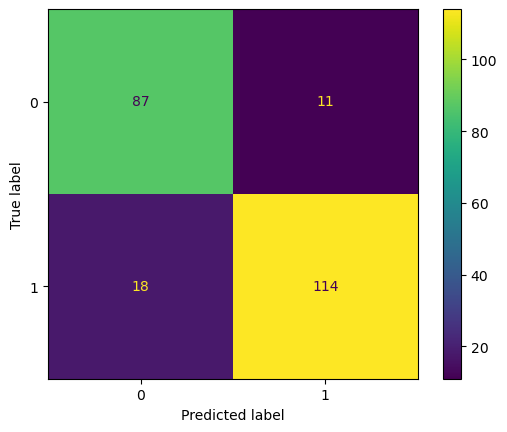

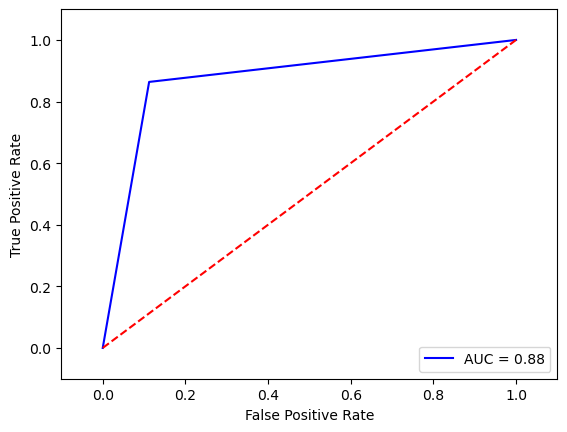

              precision    recall  f1-score   support

           0       0.83      0.89      0.86        98
           1       0.91      0.86      0.89       132

    accuracy                           0.87       230
   macro avg       0.87      0.88      0.87       230
weighted avg       0.88      0.87      0.87       230



In [15]:
from sklearn.metrics import f1_score, roc_auc_score, roc_curve, auc, recall_score, precision_score, confusion_matrix,  ConfusionMatrixDisplay, classification_report
from sklearn import metrics

# Calculate the Accuracy
accuracy=metrics.accuracy_score(y_test,y_pred)
print("accuracy is ", accuracy)

# Calculate the F1 score
f1score= f1_score(y_test, y_pred)
print("F1 Score:", f1score)

# Calculate the recall
recall = recall_score(y_test, y_pred)
print("Recall:", recall)

# Calculate the precision
precision = precision_score(y_test, y_pred)
print("Precision:", precision)

# Calculate the ROC AUC score
roc_auc = roc_auc_score(y_test, y_pred)
print("ROC AUC Score:", roc_auc)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay.from_estimator(model, X_test_imp, y_test)
plt.show()


# Plot the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, 'b', label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.1])
plt.ylim([-0.1,1.1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

print(classification_report(y_test, y_pred))
